In [1]:
from lib.models import ResNet
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms,test_evaluation
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import plotly.express as px
import pandas as pd
from lib.utils import get_bout_statistics_for_predictions
import numpy as np
device = 'cuda'

# model = ResNet(n_features=5000).to(device)
# model.load_state_dict(torch.load('alpha/model.pt'))
class CNNLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = ResNet(n_features=5000).to(device)
        self.lstm_forward = nn.LSTM(32,32)  
        self.lstm_backward = nn.LSTM(32,32)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d):
        x_2d = x_2d.view(-1,5,1,5000)
        for t in range(3):
            x_i = self.resnet(x_2d[:,t,:,:],classification=False)
            f,_ = self.lstm_forward(x_i)
        for t in range(3):
            x_i = self.resnet(x_2d[:,-t,:,:],classification=False)
            b,_ = self.lstm_backward(x_i)
        x = torch.cat([f,b],axis=1)
        x = self.fc1(x)        
        return x
model = CNNLSTM().to(device)

params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
data_dir = 'w5_centered_tiny'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_dev.pt'),batch_size=64,shuffle=True)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Params:  49590


In [2]:
lossi = []

model.train()

for i in range(1):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

  0%|          | 0/203 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 203/203 [00:27<00:00,  7.35it/s]


tensor(0.6321)


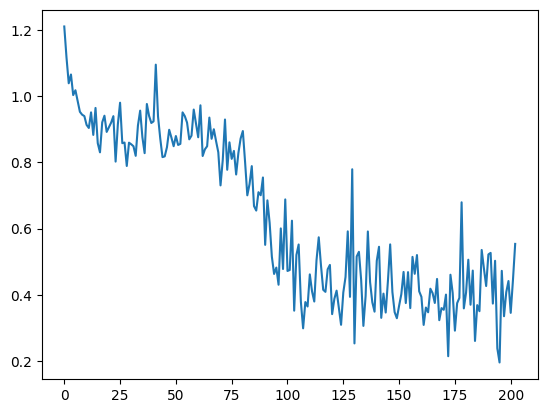

In [3]:
plt.plot(lossi)
print(torch.tensor(lossi).mean())

tensor(0.4013)


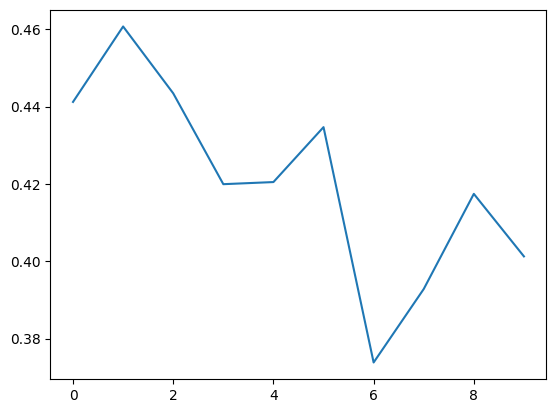

In [4]:
plt.plot(torch.tensor(lossi[100:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))
print(torch.tensor(lossi[100:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1)[-1])

100%|██████████| 203/203 [00:10<00:00, 19.07it/s]


(0.21770522139709572,
 tensor([2., 1., 1.,  ..., 1., 2., 2.]),
 tensor([2., 1., 1.,  ..., 1., 2., 2.]))

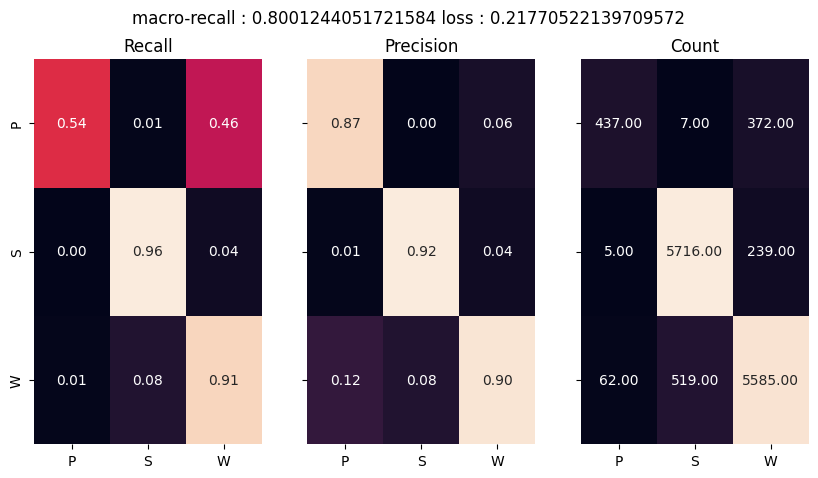

In [35]:
test_evaluation(trainloader,model,criterion)
#.1757, kernel size 8 w3
#.1708, kernel size 12 w3
#.2731, lstm w3
#.2520, w1
#.2049 bilstm w5

100%|██████████| 102/102 [00:05<00:00, 19.13it/s]


(0.23242809229037342,
 tensor([2., 1., 2.,  ..., 1., 1., 1.]),
 tensor([2., 1., 2.,  ..., 1., 1., 1.]))

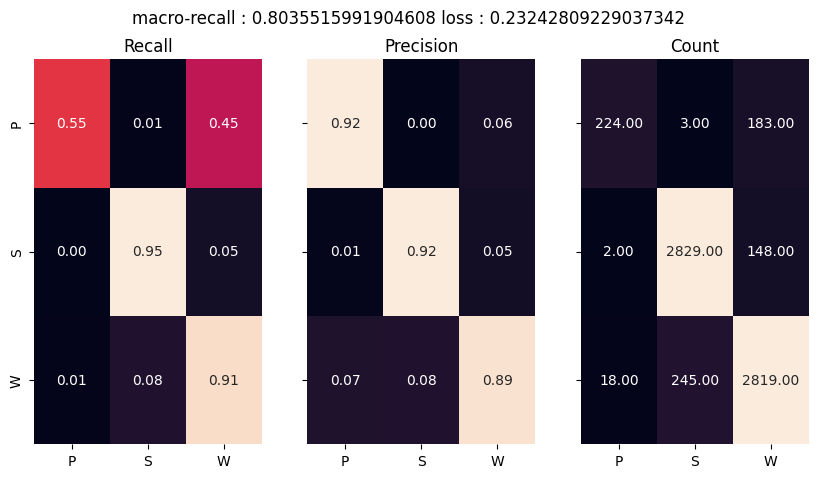

In [36]:
test_evaluation(devloader,model,criterion)
#.1799, k8 w3 
#.17705 k12 w3
#.2134 bilstm w5


In [ ]:
torch.save(model,'model.pt')

In [ ]:
X,y = next(iter(trainloader))
embedding = model(X.cuda(),classification=False)
from sklearn.manifold import TSNE
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,learning_rate='auto',init='pca')
tsne_result = tsne.fit_transform(X)
df = pd.DataFrame(tsne_result)
df['label'] = y.argmax(axis=1)
import seaborn as sns
sns.scatterplot(data=df,x=0,y=1,hue='label')